**使用[photutils](https://photutils.readthedocs.io/en/stable/index.html)构建effective PSF**  
@Author: Ray  
@Time: 2022.09.13  
@cite: https://photutils.readthedocs.io/en/stable/epsf.html

*什么是effective PSF?*  
* 仪器的PSF受很多因素影响，通常是很难去建模的，即理论建立的PSF模型通常表现不是很好。
* 而通过对视场中的恒星进行精确测光而创建的PSF模型，被称为是effective PSF，是一种经验的PSF。
* ePSF相对于仪器像素通常是过采样的

In [12]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10., 10.]
plt.rc('font',family='Times New Roman')
from astropy.visualization import simple_norm
import numpy as np

## 产生实验用图

加载图像

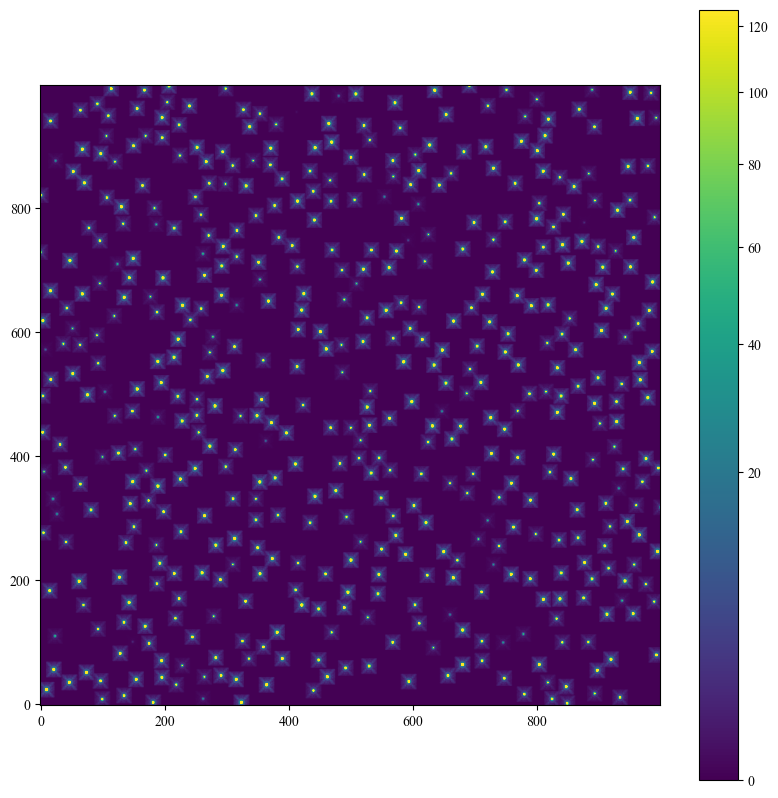

In [13]:
from photutils.datasets import load_simulated_hst_star_image

hdu = load_simulated_hst_star_image()  # 可能需要翻墙，不然会报错
data = hdu.data
hdu.header

# 查看图像
norm = simple_norm(data, 'sqrt', percent=99.)
plt.imshow(data, norm=norm, origin='lower', cmap='viridis')
plt.colorbar()

向图像中添加背景噪声

In [14]:
from photutils.datasets import make_noise_image
data += make_noise_image(
    data.shape, 
    distribution='gaussian',
    mean=10., stddev=5., seed=123
    )  

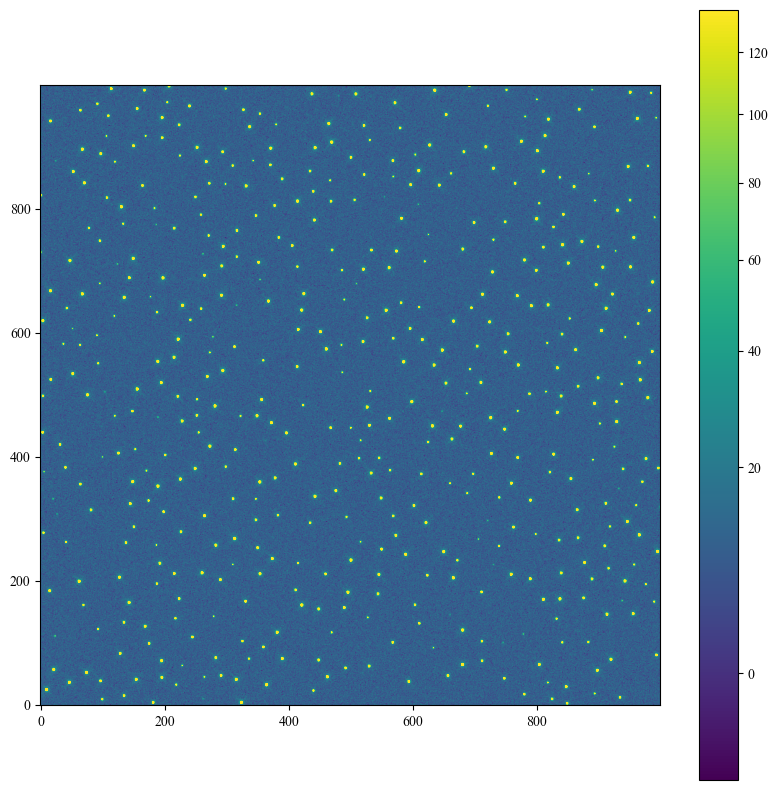

In [15]:
norm = simple_norm(data, 'sqrt', percent=99.)
plt.imshow(data, norm=norm, origin='lower', cmap='viridis')
plt.colorbar()

## 制作恒星的cutouts

寻星

In [16]:
from photutils.detection import find_peaks
peaks_tbl = find_peaks(data, threshold=500.) 
peaks_tbl.show_in_notebook(display_length=10)

idx,x_peak,y_peak,peak_value
0,849,2,1076.7025586493498
1,182,4,1709.5671124156065
2,324,4,3006.0085694164686
3,100,9,1142.9915196714978
4,824,9,1302.8604257696884
5,934,12,891.5304912385355
6,135,15,1491.0007573496678
7,780,17,965.0112131067682
8,893,18,593.8860478215643
9,440,23,1235.3081002897825


In [17]:
size = 25  # 制作25x25的cutout
hsize = (size - 1)/2

x = peaks_tbl['x_peak']
y = peaks_tbl['y_peak']
selected = (
    (x>hsize) & (x<(data.shape[1]-1-hsize)) & (y>hsize) & (y<(data.shape[0]-1-hsize))
    )

from astropy.table import Table
stars_tbl = Table()
stars_tbl['x'] = x[selected]
stars_tbl['y'] = y[selected]
stars_tbl.show_in_notebook(display_length=5)

idx,x,y
0,135,15
1,780,17
2,893,18
3,440,23
4,847,29
5,219,32
6,364,32
7,47,36
8,817,36
9,593,37


背景扣除

In [18]:
from astropy.stats import sigma_clipped_stats

mean_val, median_val, std_val = sigma_clipped_stats(data, sigma=2.)  
data -= median_val  
data

array([[-5.29487203, -2.18819854,  6.09036102, ...,  1.50402391,
        -5.66560313,  0.84631357],
       [ 5.31598478, -8.90979449,  0.61717343, ..., -6.98861959,
         5.84072573,  5.74513242],
       [-2.2706072 ,  7.17764307, -3.28222902, ...,  0.10459687,
         1.74792869, -5.93255573],
       ...,
       [ 0.36891809,  0.65036711, -3.113536  , ...,  0.41051452,
         3.69136689, -3.48413345],
       [-0.70563918, -1.36531692,  5.41295092, ..., -7.74885014,
         0.52998879,  0.56774636],
       [ 0.32947169, -6.81550815,  2.94529496, ...,  0.15696621,
         2.45174828,  0.68772825]])

提取可用的恒星

In [19]:
from astropy.nddata import NDData
nddata = NDData(data=data)

from photutils.psf import extract_stars
stars = extract_stars(data=nddata, catalogs=stars_tbl, size=size)

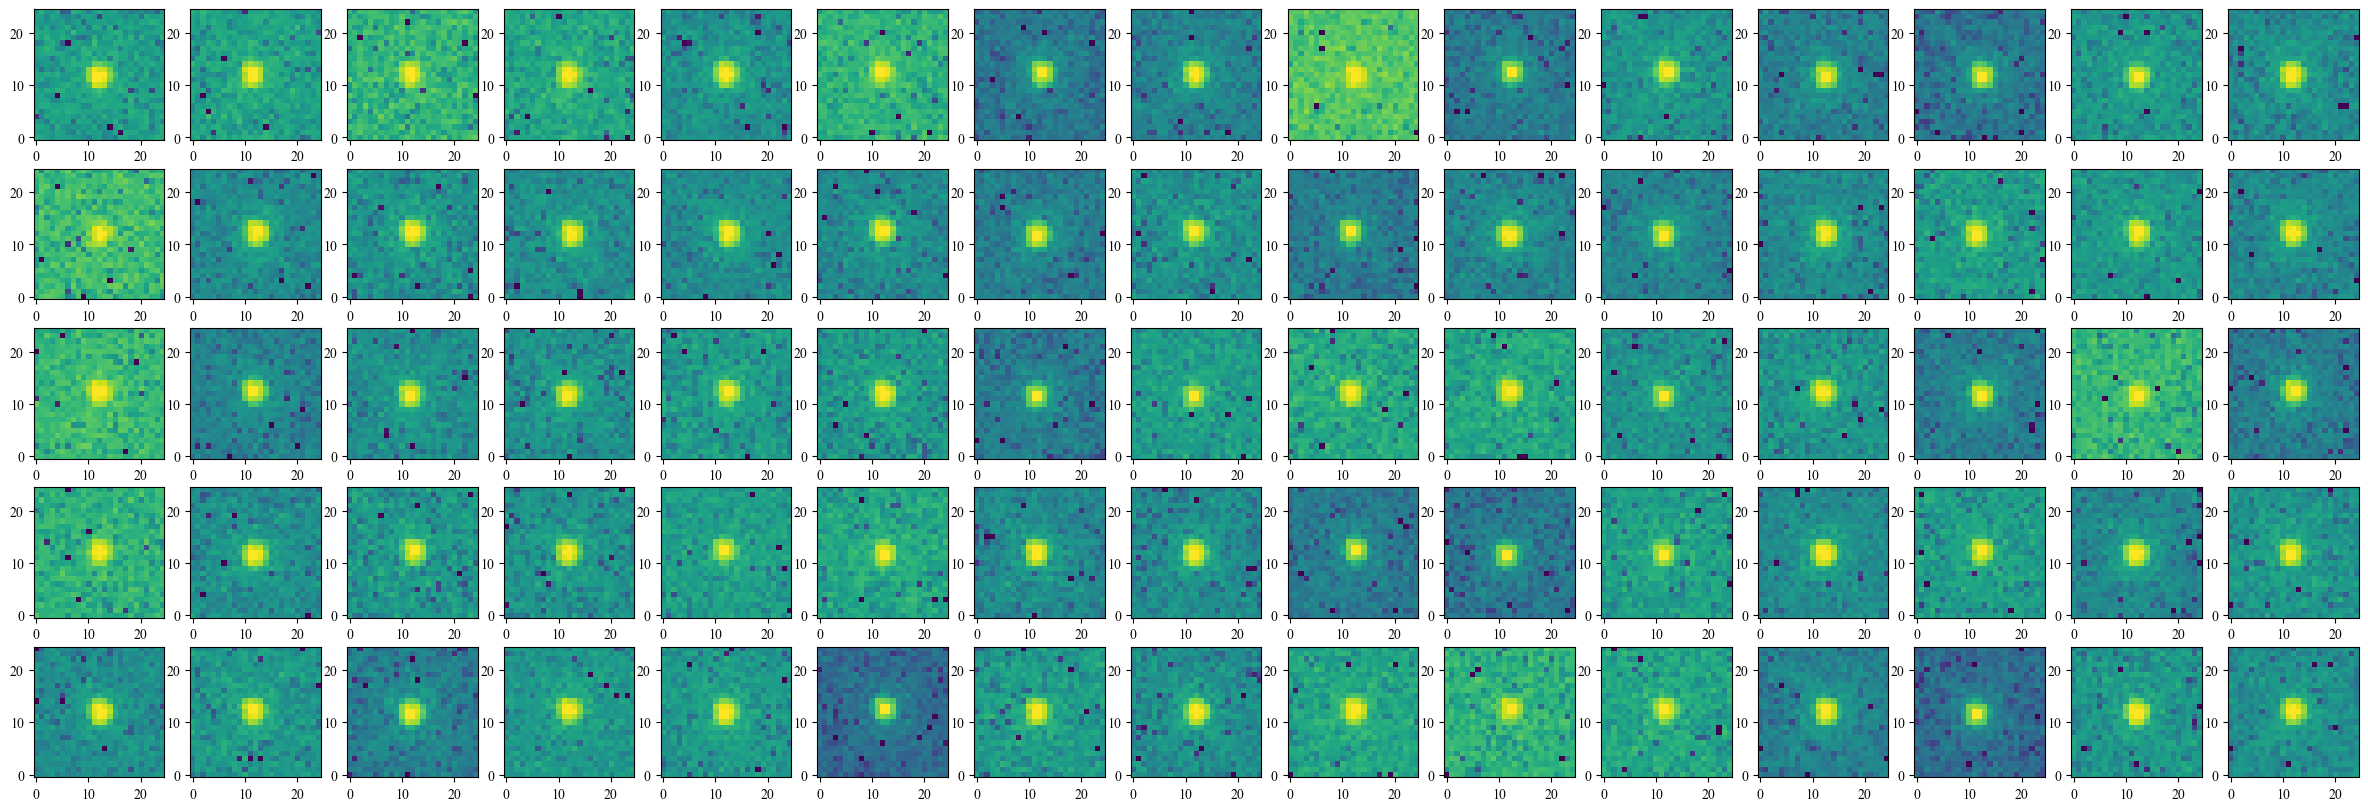

In [20]:
# 查看恒星的cutouts; 恒星一共404了，查看其中一部分的图像
nrows = 5
ncols = 15
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(2*ncols, 2*nrows), squeeze=True)
ax = ax.ravel()

for i in range(nrows * ncols):
    norm = simple_norm(stars[i], 'log', percent=99.)
    ax[i].imshow(stars[i], norm=norm, origin='lower', cmap='viridis')

## 构建ePSF

In [21]:
from photutils.psf import EPSFBuilder
epsf_builder = EPSFBuilder(
    oversampling=4, #过采样因子
    maxiters=3, 
    progress_bar=True  # 显示迭代进度
    )  
epsf, fitted_stars = epsf_builder(stars) 

/Users/rui/miniconda3/envs/astro/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
EPSFBuilder (3 maxiters): 100%|██████████| 3/3 [00:02<00:00,  1.17it/s]


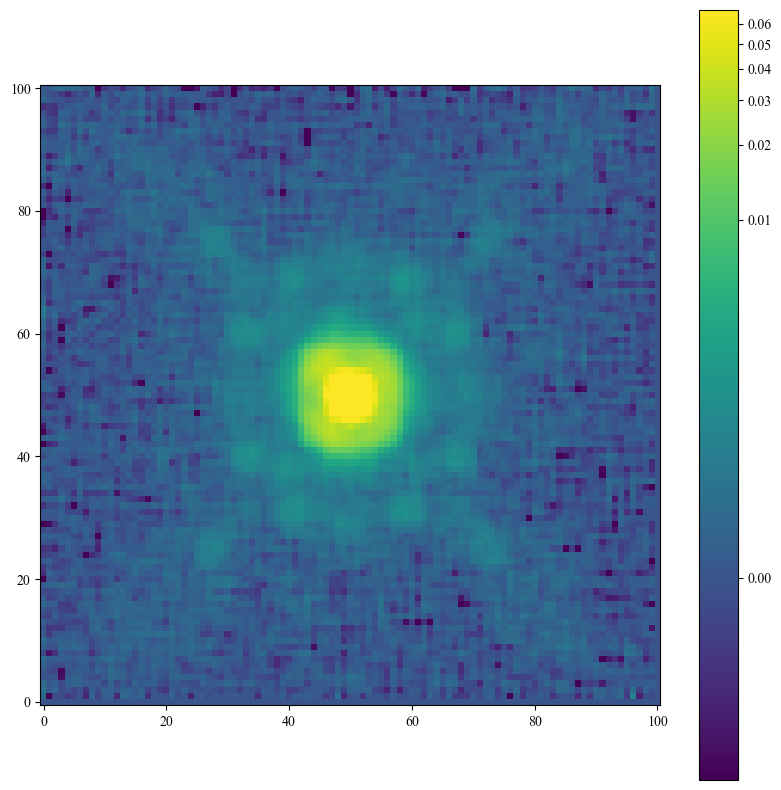

In [22]:
norm = simple_norm(epsf.data, 'log', percent=99.)
plt.imshow(epsf.data, norm=norm, origin='lower', cmap='viridis')
plt.colorbar()

---
